⚙️ Preparando entorno...
🚀 ACELERADOR: Tesla T4

📖 Cargando base de datos maestra...
✅ Total Registros: 98292
🎯 Clases: ['AMBIENTALES ' 'APOYO AL CIUDADANO ' 'FISCALIZACION Y DEFENSA CIVIL '
 'FISICA ' 'FISICA(SALUD) ' 'PROTECCION FAMILIAR ' 'SEGURIDAD '
 'TRANSITO Y SEGURIDAD VIAL ']

🤖 Vectorizando textos con BERT (Esto tomará unos minutos)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Procesando:   0%|          | 0/768 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


✂️ Generando Set de Entrenamiento y Validación...
   Train: 78633 | Test: 19659

⚖️ Calculando Pesos de Penalización...
   Pesos asignados por clase (Mayor peso = Mayor prioridad):
   - AMBIENTALES : 0.43x
   - APOYO AL CIUDADANO : 0.58x
   - FISCALIZACION Y DEFENSA CIVIL : 0.72x
   - FISICA : 112.98x
   - FISICA(SALUD) : 11.14x
   - PROTECCION FAMILIAR : 28.74x
   - SEGURIDAD : 0.93x
   - TRANSITO Y SEGURIDAD VIAL : 0.73x

🧠 Inicializando Cerebro Optimizado (448 neuronas)...
🔥 Entrenando con Pesos de Clase...


Training:   0%|          | 0/40 [00:00<?, ?it/s]


🕵️‍♂️ Evaluando rendimiento real...

🏆 RESULTADOS V4: COST-SENSITIVE LEARNING
                                precision    recall  f1-score   support

                  AMBIENTALES        0.77      0.73      0.75      5666
           APOYO AL CIUDADANO        0.54      0.37      0.44      4235
FISCALIZACION Y DEFENSA CIVIL        0.61      0.62      0.61      3415
                       FISICA        0.06      0.23      0.10        22
                FISICA(SALUD)        0.16      0.16      0.16       220
          PROTECCION FAMILIAR        0.03      0.07      0.04        86
                    SEGURIDAD        0.50      0.67      0.57      2644
    TRANSITO Y SEGURIDAD VIAL        0.60      0.68      0.64      3371

                      accuracy                           0.61     19659
                     macro avg       0.41      0.44      0.41     19659
                  weighted avg       0.62      0.61      0.60     19659



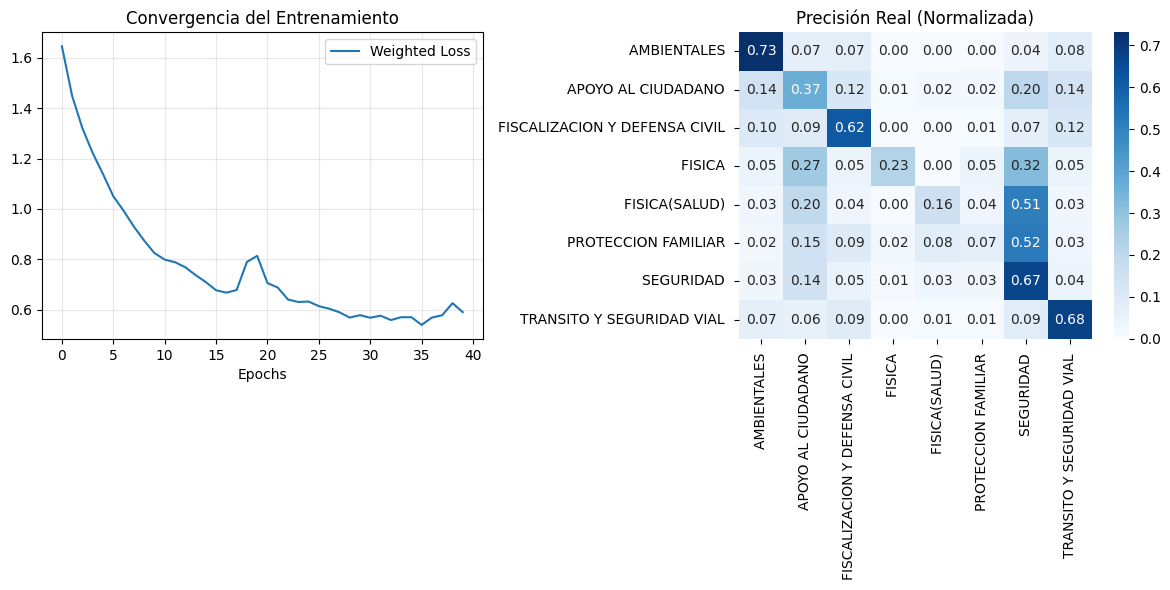

💾 Modelo guardado como 'modelo_tesis_final_v4.pth'


In [1]:
################################################################################
#                                                                              #
#                         PROJECT EVO - VERSION 4.0                            #
#                           ProjectEvo_V4.ipynb                                #
#                                                                              #
################################################################################

# --- 1. SETUP ---
import shutil
import os
print("⚙️ Preparando entorno...")
if shutil.which("uv") is None:
    !pip install uv -q
!uv pip install --system -q torch transformers pandas numpy scikit-learn tqdm matplotlib seaborn

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel, logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from google.colab import drive
from tqdm.notebook import tqdm

# Configuración
logging.set_verbosity_error()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 ACELERADOR: {torch.cuda.get_device_name(0)}")

# --- 2. CARGA DE DATOS COMPLETA ---
RUTE_ARCHIVO = 'https://raw.githubusercontent.com/berniehans/DataCallao/main/v2_dataset_callao.csv'

print("\n📖 Cargando base de datos maestra...")
df_full = pd.read_csv(RUTE_ARCHIVO, sep=';', encoding='latin1', usecols=['DESCRIPCION_OCURRENCIA', 'TIPOLOGIA'])
df_full = df_full.dropna().reset_index(drop=True)

# Codificación
encoder = LabelEncoder()
y_full = encoder.fit_transform(df_full['TIPOLOGIA'])
CLASES_NAMES = encoder.classes_
NUM_CLASSES = len(CLASES_NAMES)
X_text_full = df_full['DESCRIPCION_OCURRENCIA'].astype(str).tolist()

print(f"✅ Total Registros: {len(df_full)}")
print(f"🎯 Clases: {CLASES_NAMES}")

# --- 3. BERT EMBEDDINGS (BATCH PROCESSING) ---
print("\n🤖 Vectorizando textos con BERT (Esto tomará unos minutos)...")
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
bert_model = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased').to(DEVICE)
bert_model.eval()

embeddings_list = []
BATCH_SIZE = 128

for i in tqdm(range(0, len(X_text_full), BATCH_SIZE), desc="Procesando"):
    batch_text = X_text_full[i : i + BATCH_SIZE]
    inputs = tokenizer(batch_text, return_tensors="pt", padding=True, truncation=True, max_length=64).to(DEVICE)
    with torch.no_grad():
        out = bert_model(**inputs).pooler_output.cpu().numpy()
        embeddings_list.append(out)

X_full_emb = np.concatenate(embeddings_list, axis=0)

# Limpieza de memoria
del bert_model, tokenizer, inputs, embeddings_list
torch.cuda.empty_cache()
gc.collect()

# --- 4. DIVISIÓN DE DATOS (REALISTA) ---
print("\n✂️ Generando Set de Entrenamiento y Validación...")
# 80% Train, 20% Test (Estratificado para asegurar que haya clases raras en ambos)
X_train, X_test, y_train, y_test = train_test_split(
    X_full_emb, y_full, test_size=0.20, random_state=42, stratify=y_full
)

print(f"   Train: {len(X_train)} | Test: {len(X_test)}")

# --- 5. CÁLCULO DE PESOS DE CLASE (EL ARMA SECRETA) ---
print("\n⚖️ Calculando Pesos de Penalización...")
# Calculamos qué tan rara es cada clase para darle un "superpoder" en el entrenamiento
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convertimos a Tensor para PyTorch
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

print("   Pesos asignados por clase (Mayor peso = Mayor prioridad):")
for cls, w in zip(CLASES_NAMES, class_weights):
    print(f"   - {cls}: {w:.2f}x")

# --- 6. PREPARACIÓN DE TENSORES ---
# Normalización (Vital para redes neuronales)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_gpu = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_train_gpu = torch.tensor(y_train, dtype=torch.long).to(DEVICE)
X_test_gpu = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

# --- 7. ARQUITECTURA OPTIMIZADA (DEL GA) ---
# Usamos los genes ganadores de la V3.1
NEURONS = 448
DROPOUT = 0.16
LR = 0.00273

print(f"\n🧠 Inicializando Cerebro Optimizado ({NEURONS} neuronas)...")

model = nn.Sequential(
    nn.Linear(768, NEURONS),
    nn.BatchNorm1d(NEURONS),
    nn.ReLU(),
    nn.Dropout(DROPOUT),
    nn.Linear(NEURONS, NUM_CLASSES)
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# AQUÍ ESTÁ LA MAGIA: Le pasamos los pesos a la función de error
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# --- 8. ENTRENAMIENTO FINAL ---
print("🔥 Entrenando con Pesos de Clase...")
EPOCHS = 40
BATCH_SIZE_TRAIN = 256
loss_hist = []

model.train()
for epoch in tqdm(range(EPOCHS), desc="Training"):
    perm = torch.randperm(len(X_train_gpu))
    epoch_loss = 0

    for i in range(0, len(X_train_gpu), BATCH_SIZE_TRAIN):
        idx = perm[i : i + BATCH_SIZE_TRAIN]
        optimizer.zero_grad()
        out = model(X_train_gpu[idx])
        loss = criterion(out, y_train_gpu[idx]) # La loss usa los pesos aquí
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_hist.append(epoch_loss / (len(X_train_gpu)/BATCH_SIZE_TRAIN))

# --- 9. EVALUACIÓN Y RESULTADOS ---
print("\n🕵️‍♂️ Evaluando rendimiento real...")
model.eval()
with torch.no_grad():
    outputs = model(X_test_gpu)
    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()

print("\n" + "="*60)
print(f"🏆 RESULTADOS V4: COST-SENSITIVE LEARNING")
print("="*60)

# Reporte
print(classification_report(y_test, y_pred, target_names=CLASES_NAMES))

# Matriz
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, label="Weighted Loss")
plt.title("Convergencia del Entrenamiento")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=CLASES_NAMES, yticklabels=CLASES_NAMES)
plt.title("Precisión Real (Normalizada)")
plt.tight_layout()
plt.show()

# Guardar
print("💾 Modelo guardado como 'modelo_tesis_final_v4.pth'")
torch.save(model.state_dict(), "modelo_tesis_final_v4.pth")